In [1]:
import numpy as np
import scipy.stats
import sklearn.decomposition
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none' # export SVG text as text, not paths
plt.rcParams['axes.facecolor'] = 'w' # white axes background
plt.rcParams['savefig.facecolor'] = 'w' # white main background, for blog posts

# Part 2: Leader Bias Distributions by Demographic Group

## 0. Loading Civ5 data as in Part 1, and new Civ5 metadata

In [2]:
df = pd.read_csv('civdata.csv', index_col=0).T # Part 1 data
print(df.shape)
df.head()

(43, 63)


,Boldness,Chattiness,Denounce Willingness,Diplomatic Balance,Friendship Willingness,Forgiveness,Loyalty,Meanness,City-State Competitiveness,Neediness,...,Friendly,Guarded,Hostile,Neutrality,War,CS Bully,CS Conquest,CS Friendly,CS Ignore,CS Protect
Ahmad al-Mansur,4,6,5,5,6,5,6,5,5,6,...,8,6,4,5,5,4,4,6,4,6
Alexander,8,7,7,3,4,5,4,7,3,4,...,5,5,7,4,6,3,4,5,4,8
Ashurbanipal,6,3,6,5,5,4,5,5,3,4,...,5,5,6,5,8,5,7,4,4,3
Askia,7,5,5,6,6,4,6,6,4,4,...,6,6,6,5,7,7,8,5,5,4
Attila,8,5,6,4,3,4,4,8,3,3,...,3,3,8,5,8,8,7,4,5,3


In [3]:
''' Convert encoding to UTF-8 and drop empty rows/columns if necessary '''
df_meta = pd.read_csv('civmetadata.csv', index_col=0)
print(df_meta.shape)
df_meta.head()

(43, 8)


,Born,Death,Age,Era,Gender,Civilization,Continent,Region
Leader,,,,,,,,
Ahmad al-Mansur,1549.0,1603.0,54.0,Renaissance,Male,Morrocan,Africa,Africa
Alexander,-356.0,-323.0,33.0,Classical,Male,Greek,Europe,Europe
Ashurbanipal,-685.0,-627.0,58.0,Ancient,Male,Assyrian,Asia,Middle East
Askia,1442.0,1538.0,96.0,Renaissance,Male,Songhai,Africa,Africa
Attila,406.0,453.0,47.0,Classical,Male,Hunnic,Asia,Asia


## 1. Examine raw distributions by era, gender, and region

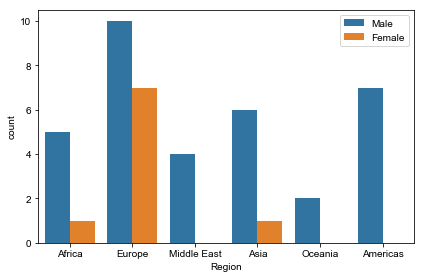

In [4]:
%matplotlib inline
''' Counts by region and gender '''
sns.countplot(x='Region', hue='Gender', data=df_meta)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('figures/region_gender_counts.png', format='png', dpi=90)

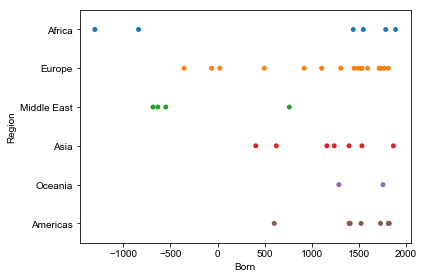

In [5]:
''' Distribution by region and leader date of birth '''
sns.stripplot(x='Born', y='Region', data=df_meta)
plt.tight_layout()
plt.savefig('figures/region_year_counts.png', format='png', dpi=90)

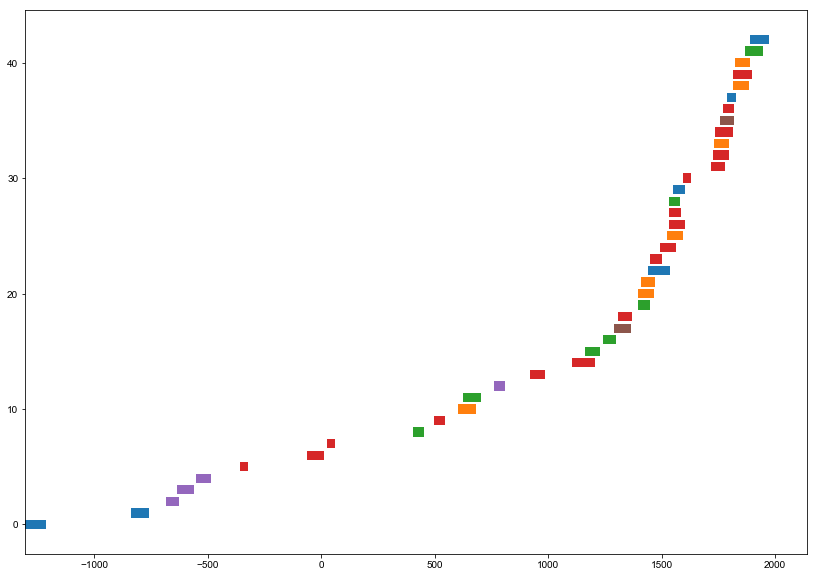

In [6]:
''' Distribution by region and leader lifetime (unused in post)'''
regions = sorted(df_meta['Region'].unique())
df_meta_sorted = df_meta.sort_values('Born')
df_meta_sorted['Born_Rank'] = range(df_meta.shape[0])

fig, ax = plt.subplots(1,1,figsize=(14,10))
for i,region in enumerate(regions):
    df_region = df_meta_sorted[df_meta_sorted['Region'] == region]
    ax.barh(bottom=df_region['Born_Rank'].values, 
             width=df_region['Death'].values - df_region['Born'].values,
             left=df_region['Born'])

## 2. PCA biplots with metadata

### 2.1 Repeating PCA same as in Part 1

In [7]:
''' Center values such that each feature has mean 0
    Not scaling for variance since all values already bounded 1-12 '''
X = df.values
means = X.mean(axis=0)
X_cent = X - means[np.newaxis,:]
df_cent = pd.DataFrame(index=df.index, columns=df.columns, data=X_cent)

pca = sklearn.decomposition.PCA(n_components=np.min(X_cent.shape))
pca.fit(X_cent)
top2pcs = pca.transform(X_cent)[:,:2] # coordinates of leaders in top 2 PC space
top2var = pca.explained_variance_ratio_[:2] # variance explained by top 2 PCs

### 2.2 Plotting the same biplot from Part 1, but color-coded with demographic data

In [8]:
''' Define a function to create an attributed-color PCA plot '''
def pca_with_metadata(attribute, ax, value_order=None):
    df_pca = pd.DataFrame(index=df.index, columns=['X','Y'], data=top2pcs)
    value_order = value_order if value_order else sorted(df_meta.loc[:,attribute].unique())
    for unique_value in value_order:
        df_cat = df_pca[df_meta[attribute] == unique_value]
        ax.scatter(df_cat['X'], df_cat['Y'], label=unique_value)
    ax.set_xlabel('PC1 (' + str(round(100*top2var[0],1)) + '%)')
    ax.set_ylabel('PC2 (' + str(round(100*top2var[1],1)) + '%)')
    ax.axvline(x=0, ymin=np.min(top2pcs[:,1]), ymax=np.max(top2pcs[:,1]), color='lightgray', ls='--')
    ax.axhline(y=0, xmin=np.min(top2pcs[:,0]), xmax=np.max(top2pcs[:,0]), color='lightgray', ls='--')
    ax.legend()
    plt.tight_layout()

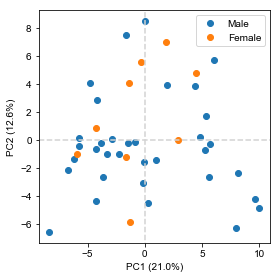

In [9]:
''' Gender annotated biplot '''
fig, ax = plt.subplots(1,1,figsize=(4,4))
pca_with_metadata('Gender', ax, ['Male','Female'])
plt.savefig('figures/pca_biplot_gender.png', format='png', dpi=90)

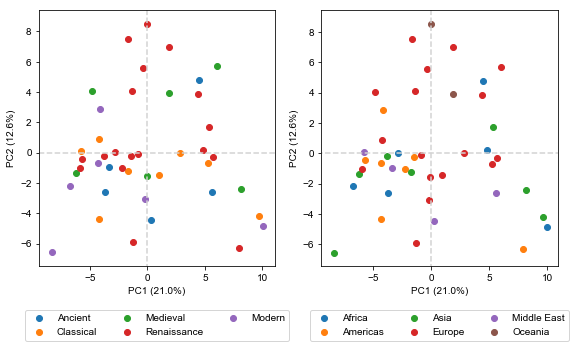

In [10]:
''' Era and Region annotated biplots '''
fig, axs = plt.subplots(1,2,figsize=(8,4))
pca_with_metadata('Era', axs[0], ['Ancient', 'Classical' ,'Medieval', 'Renaissance', 'Modern'])
pca_with_metadata('Region', axs[1])

for ax in axs: # move legends to bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()
plt.savefig('figures/pca_biplot_era_region.png', format='png', dpi=90, bbox_inches='tight')

## 3. Association studies of leader biases vs. leader demographics

In [11]:
''' Ignore these biases that have no variability between leaders '''
ignore_biases = ['Trade Origin', 'Trade Destination', 'Sea Trade', 'Land Trade', 'Airlift', 'Archaeology']

### 3.1 Leader biases vs. gender: Mann-Whitney U-test

In [12]:
''' Constructing leader groups by gender '''
male_leaders = (df_meta[df_meta['Gender'] == 'Male']).index
female_leaders = (df_meta[df_meta['Gender'] == 'Female']).index
print 'Male Leaders:', len(male_leaders)
print 'Female Leaders:', len(female_leaders)

Male Leaders: 34
Female Leaders: 9


In [13]:
''' Applying Mann-Whitney U-tests '''
biases = filter(lambda x: not x in ignore_biases, df.columns)
df_mwtest = pd.DataFrame(index=biases, columns=['U', 'p', 'log10(p)'])
for bias in biases:
    male_values = df.loc[male_leaders, bias].values
    female_values = df.loc[female_leaders, bias].values
    U, pval = scipy.stats.mannwhitneyu(male_values, female_values)
    df_mwtest.at[bias, 'U'] = U
    df_mwtest.at[bias, 'p'] = pval
    df_mwtest.at[bias, 'log10(p)'] = np.log10(pval)

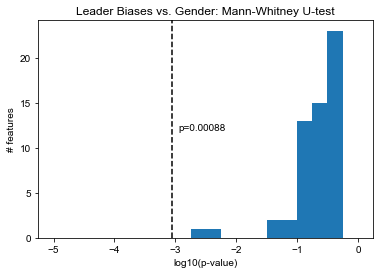

In [14]:
''' Plotting p-value distribution with Bonferroni-corrected significance threshold '''
threshold = 0.05 / df_mwtest.shape[0]
log_pvals = df_mwtest.loc[:,'log10(p)'].values.astype(float)
plt.hist(log_pvals, bins=np.arange(-5,0.25,0.25))
plt.axvline(x=np.log10(threshold), c='k', ls='--')
plt.xlabel('log10(p-value)')
plt.ylabel('# features')
plt.text(np.log10(threshold)+0.1, 12, 'p=0.00088')
plt.title('Leader Biases vs. Gender: Mann-Whitney U-test')
plt.savefig('figures/bias_vs_gender_mann-whitney_pvalues.png', format='png', dpi=90)

In [15]:
df_mwtest.sort_values('log10(p)').head()

,U,p,log10(p)
Chattiness,61,0.00252772,-2.59727
City-State Competitiveness,68,0.00491535,-2.30845
Deceptive,91.5,0.0318327,-1.49713
Denounce Willingness,97.5,0.0456952,-1.34013
Build Nuke,104.5,0.0646509,-1.18943


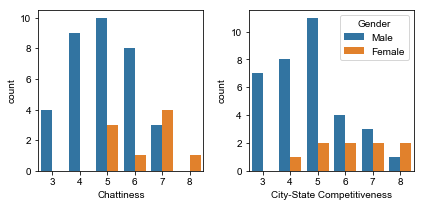

In [16]:
''' Examining bias distributions by gender for top two (note: not statistically significant) '''
fig, axs = plt.subplots(1, 2, figsize=(6,3))
df_tmp = pd.concat([df.loc[:,'Chattiness'], df_meta.loc[:,'Gender']], axis=1)
sns.countplot(x='Chattiness', hue='Gender', data=df_tmp, ax=axs[0])
df_tmp = pd.concat([df.loc[:,'City-State Competitiveness'], df_meta.loc[:,'Gender']], axis=1)
sns.countplot(x='City-State Competitiveness', hue='Gender', data=df_tmp, ax=axs[1])
axs[0].get_legend().remove()
plt.tight_layout()
plt.savefig('figures/gender_top_bias_split.png', format='png', dpi=90)

### 3.2 Leader biases vs. era: Kruskal-Wallis test

In [17]:
''' Applying Kruskal-Wallis test for era '''
biases = filter(lambda x: not x in ignore_biases, df.columns)
df_kruskal_era = pd.DataFrame(index=biases, columns=['H', 'p', 'log10(p)'])
eras = ['Ancient', 'Classical', 'Medieval', 'Renaissance', 'Modern']
era_values = []
for bias in biases:
    for era in eras:
        era_values.append(df.loc[df_meta['Era'] == era, bias].values)
    H, pval = scipy.stats.kruskal(*era_values)
    df_kruskal_era.at[bias, 'H'] = H
    df_kruskal_era.at[bias, 'p'] = pval
    df_kruskal_era.at[bias, 'log10(p)'] = np.log10(pval)

In [18]:
df_kruskal_era.sort_values('log10(p)').head()

,H,p,log10(p)
CS Ignore,386.608,2.05236e-05,-4.68775
CS Protect,391.49,2.36869e-05,-4.62549
Neutrality,352.865,3.93733e-05,-4.4048
Hostile,344.762,5.48856e-05,-4.26054
Friendly,332.146,6.25315e-05,-4.2039


In [19]:
df_kruskal_era[df_kruskal_era['p'] < threshold].sort_values('log10(p)')

,H,p,log10(p)
CS Ignore,386.608,2.05236e-05,-4.68775
CS Protect,391.49,2.36869e-05,-4.62549
Neutrality,352.865,3.93733e-05,-4.4048
Hostile,344.762,5.48856e-05,-4.26054
Friendly,332.146,6.25315e-05,-4.2039
Guarded,336.954,7.32004e-05,-4.13549
War,354.13,7.70964e-05,-4.11297
CS Bully,359.28,8.48833e-05,-4.07118
Afraid,317.961,9.00862e-05,-4.04534
Deceptive,323.384,9.62487e-05,-4.01661


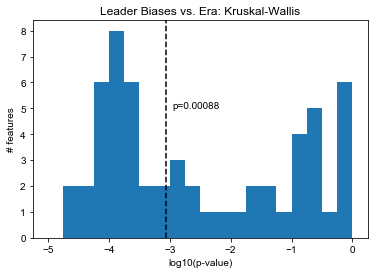

In [20]:
''' Plotting p-value distribution with Bonferroni-corrected significance threshold '''
threshold = 0.05 / df_kruskal_era.shape[0]
log_pvals = df_kruskal_era.loc[:,'log10(p)'].values.astype(float)
plt.hist(log_pvals, bins=np.arange(-5,0.25,0.25))
plt.axvline(x=np.log10(threshold), c='k', ls='--')
plt.xlabel('log10(p-value)')
plt.ylabel('# features')
plt.text(np.log10(threshold)+0.1, 5, 'p=0.00088')
plt.title('Leader Biases vs. Era: Kruskal-Wallis')
plt.savefig('figures/bias_vs_era_kruskal_pvalues.png', format='png', dpi=90)

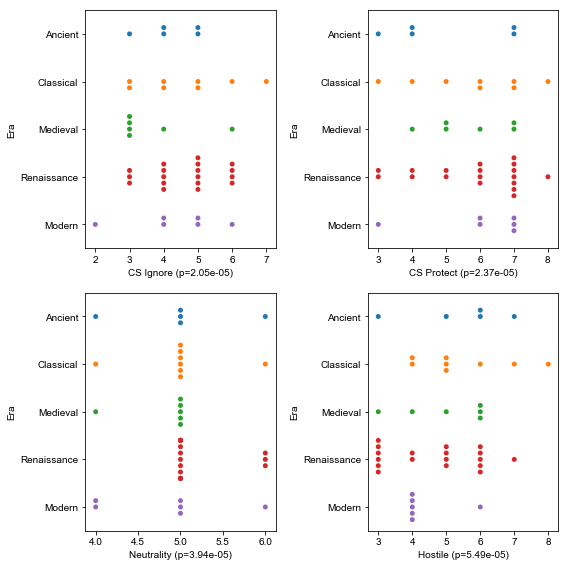

In [21]:
''' Examining bias distributions by era for top four '''
fig, axs = plt.subplots(2, 2, figsize=(8,8))
axs = axs.flatten()
for i,bias in enumerate(df_kruskal_era.sort_values('log10(p)').index[:4]):
    df_tmp = pd.concat([df.loc[:,bias], df_meta.loc[:,'Era']], axis=1)
    axs[i] = sns.swarmplot(x=bias, y='Era', data=df_tmp, ax=axs[i], order=eras)
    axs[i].set_xlabel(bias + ' (p=' + '{:0.2e}'.format(df_kruskal_era.loc[bias,'p']) + ')')
plt.tight_layout()
plt.savefig('figures/era_top_bias_split.png', format='png', dpi=90)

### 3.3 Leader biases vs. region: Kruskal–Wallis test

In [22]:
''' Applying Kruskal-Wallis test for region '''
biases = filter(lambda x: not x in ignore_biases, df.columns)
df_kruskal_region = pd.DataFrame(index=biases, columns=['H', 'p', 'log10(p)'])
regions = ['Americas', 'Africa', 'Asia', 'Europe', 'Middle East'] # exclude Oceania, only 2 instances
region_values = []
for bias in biases:
    for region in regions:
        region_values.append(df.loc[df_meta['Region'] == region, bias].values)
    H, pval = scipy.stats.kruskal(*region_values)
    df_kruskal_region.at[bias, 'H'] = H
    df_kruskal_region.at[bias, 'p'] = pval
    df_kruskal_region.at[bias, 'log10(p)'] = np.log10(pval)

In [23]:
df_kruskal_region[df_kruskal_region['p'] < threshold].sort_values('log10(p)')

,H,p,log10(p)
CS Protect,379.569,0.000126482,-3.89797
CS Ignore,371.268,0.000178013,-3.74955
Afraid,312.03,0.000215239,-3.66708
Neutrality,336.22,0.00041286,-3.3842
Wonder,300.662,0.000472685,-3.32543
Deceptive,312.109,0.000478977,-3.31969
Friendly,317.119,0.000529813,-3.27588
Hostile,328.395,0.000544366,-3.26411
CS Bully,344.369,0.000633811,-3.19804
Guarded,321.394,0.00064359,-3.19139


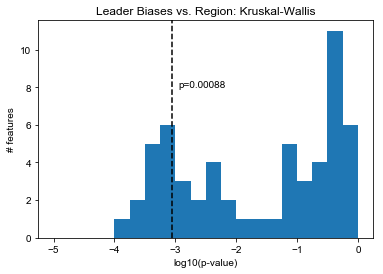

In [24]:
''' Plotting p-value distribution with Bonferroni-corrected significance threshold '''
threshold = 0.05 / df_kruskal_region.shape[0]
log_pvals = df_kruskal_region.loc[:,'log10(p)'].values.astype(float)
plt.hist(log_pvals, bins=np.arange(-5,0.25,0.25))
plt.axvline(x=np.log10(threshold), c='k', ls='--')
plt.xlabel('log10(p-value)')
plt.ylabel('# features')
plt.text(np.log10(threshold)+0.1, 8, 'p=0.00088')
plt.title('Leader Biases vs. Region: Kruskal-Wallis')
plt.savefig('figures/bias_vs_region_kruskal_pvalues.png', format='png', dpi=90)

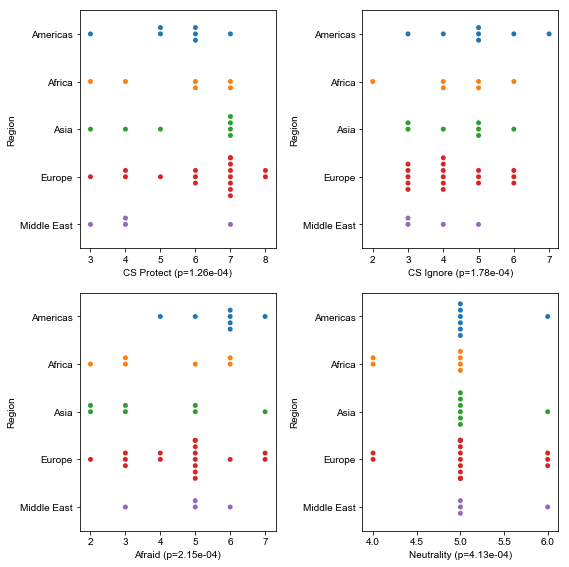

In [25]:
''' Examining bias distributions by region for top four '''
fig, axs = plt.subplots(2, 2, figsize=(8,8))
axs = axs.flatten()
for i,bias in enumerate(df_kruskal_region.sort_values('log10(p)').index[:4]):
    df_tmp = pd.concat([df.loc[:,bias], df_meta.loc[:,'Region']], axis=1)
    axs[i] = sns.swarmplot(x=bias, y='Region', data=df_tmp, ax=axs[i], order=regions)
    axs[i].set_xlabel(bias + ' (p=' + '{:0.2e}'.format(df_kruskal_region.loc[bias,'p']) + ')')
plt.tight_layout()
plt.savefig('figures/region_top_bias_split.png', format='png', dpi=90)